**Object Localization Project:**
---
step by step approach: 
---
1) Detect synthetic white shape over black background

2) Detect a cat over a black background

3) Detect a cat over natural background

4) Detect if there is a cat over natural background

5) detect objects from multiple classes

all data from - https://drive.google.com/drive/folders/1YsxDywjUZi-l_YgzXt__9__eUU-I_6EH?usp=sharing

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.utils import  plot_model
import matplotlib.pyplot as plt

BATCH_SIZE = 64
EPOCH_SIZE = 64

# First Step

**First Step** - detect synthetic white shape over black background

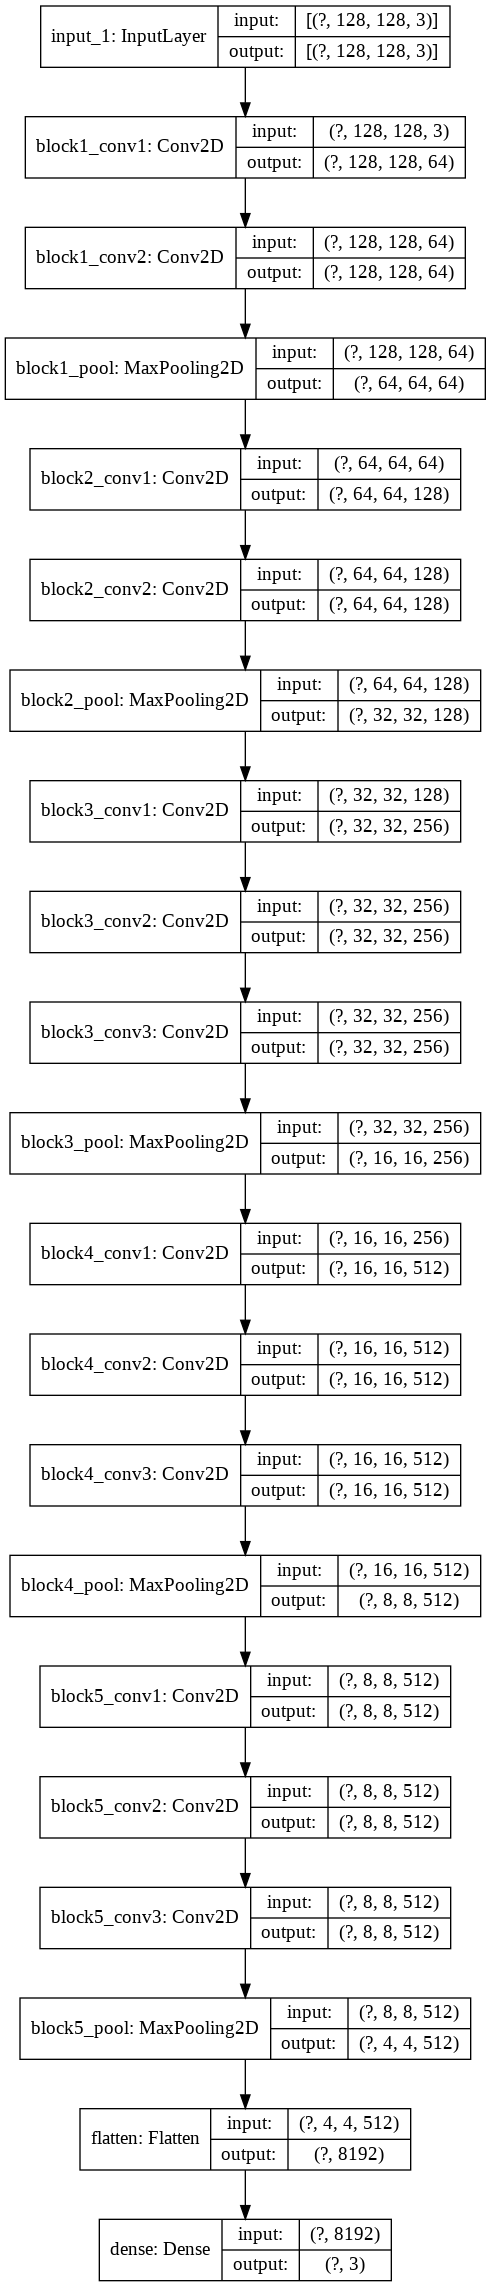

In [2]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model1 = Model(vgg.input, x)
model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model1, "first_model.png",show_shapes=True,expand_nested=False)

create a circle-generator

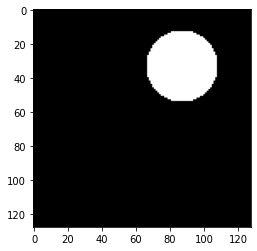

In [3]:
from matplotlib.patches import Circle

def synthetic_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        x = np.random.randint(8,120)
        y = np.random.randint(8,120)
        a = min(128 - max(x,y), min(x,y))
        r = np.random.randint(4,a)
        for x_i in range(128):
          for y_i in range(128):
            if ((x_i - x)**2) + ((y_i - y)**2) < r**2:
              X[i, x_i, y_i,:] = 1
        Y[i,0] = (x-r)/128.
        Y[i,1] = (y-r)/128.
        Y[i,2] = 2*r / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(synthetic_gen())
plt.imshow(x[0])

train the model

In [4]:
# needs steps per epoch since the generator is infinite
model1.fit_generator(synthetic_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
64/64 [==============================] - 51s 794ms/step - loss: 0.5791
Epoch 2/5
64/64 [==============================] - 52s 809ms/step - loss: 0.4958
Epoch 3/5
64/64 [==============================] - 51s 804ms/step - loss: 0.4936
Epoch 4/5
64/64 [==============================] - 52s 811ms/step - loss: 0.4912
Epoch 5/5
64/64 [==============================] - 52s 806ms/step - loss: 0.4923


predict results

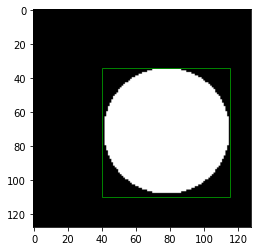

In [5]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[1]*128,p[0]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(synthetic_gen())
# predict
pred = model1.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)


# Second Step

**Second Step**-detect a cat over a black background

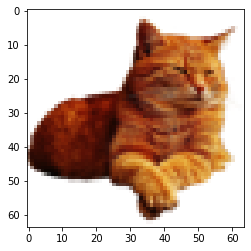

(64, 64, 4)

In [6]:
from PIL import Image

cat_pil = Image.open("cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)
plt.imshow(cat)
plt.show()


cat.shape

create a cat generator

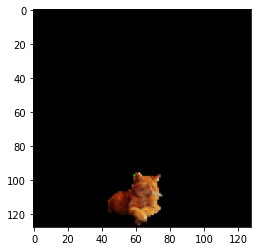

In [7]:
from matplotlib.patches import Circle

def cat_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        # resize the cat
        size = np.random.randint(32,64)
        temp_cat = cat_pil.resize((size,size))
        cat = np.asarray(temp_cat) / 255.
        cat_x, cat_y, _ = cat.shape
        bg = Image.new('RGB', (128, 128))

        x1 = np.random.randint(1,128 - cat_x)
        y1 = np.random.randint(1,128 - cat_y)
        h = cat_x
        w = cat_y

        bg.paste(temp_cat, (x1, y1))
        cat = np.asarray(bg) / 255.
        X[i] = cat

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = cat_x / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(cat_gen())
plt.imshow(x[0])

create a model

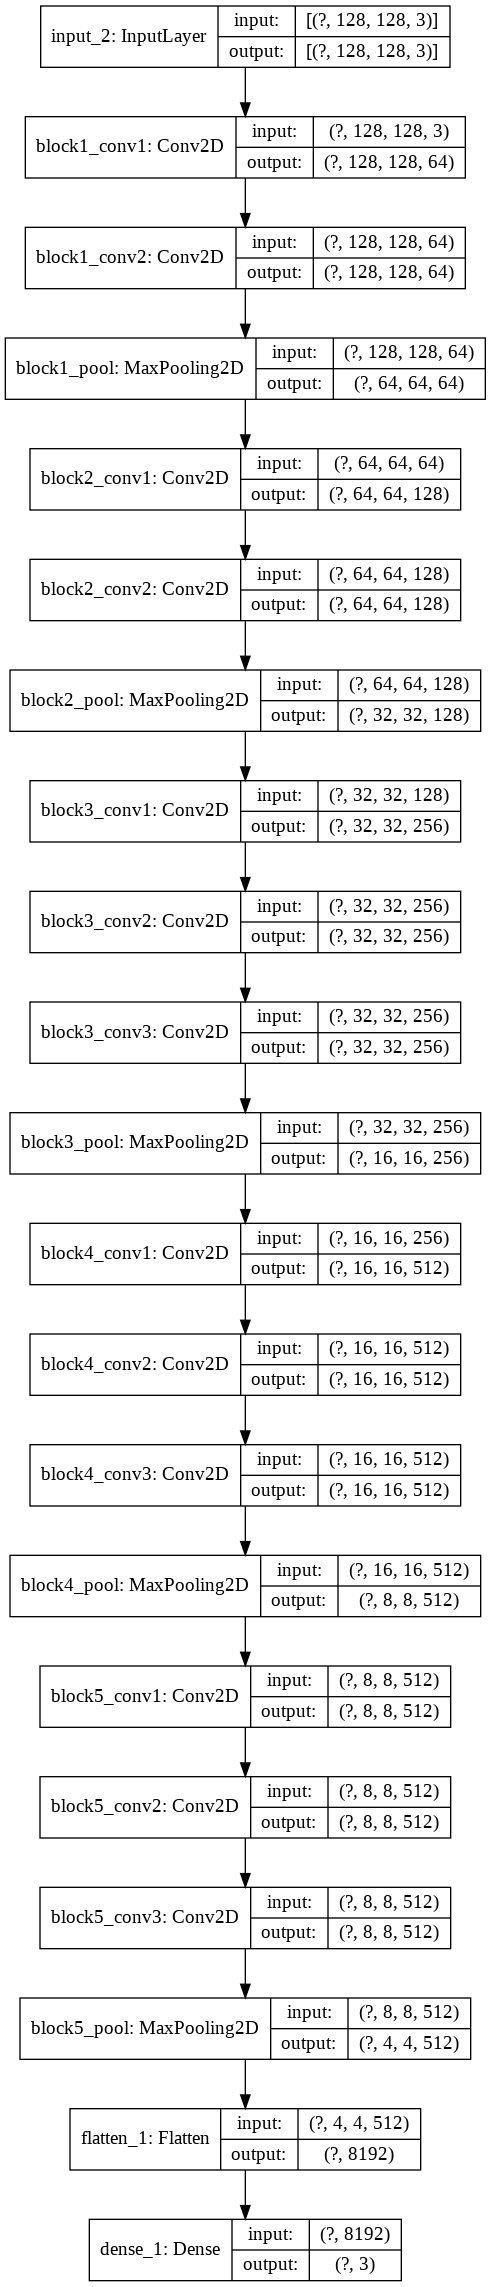

In [8]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model2 = Model(vgg.input, x)
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model2, "second_model.png",show_shapes=True)

train

In [9]:
# needs steps per epoch since the generator is infinite
model2.fit_generator(cat_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

Epoch 1/5
64/64 [==============================] - 9s 144ms/step - loss: 0.7084
Epoch 2/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5774
Epoch 3/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5734
Epoch 4/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5773
Epoch 5/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5730


predict results

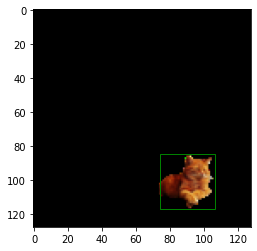

In [10]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(cat_gen())
# predict
pred = model2.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)

# Third Step

**Third Step** - detect a cat over natural background

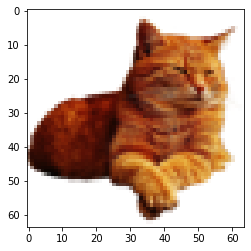

(64, 64, 4)

In [11]:
from PIL import Image

cat_pil = Image.open("cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)
plt.imshow(cat)
plt.show()


cat.shape

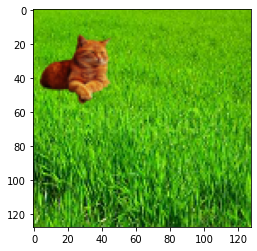

In [12]:
def natural_cat_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        # resize the cat
        size = np.random.randint(32,64)
        temp_cat = cat_pil.resize((size,size))
        cat = np.asarray(temp_cat) / 255.
        cat_x, cat_y, _ = cat.shape
        # background image
        bg_name = f'bg{np.random.randint(1,4)}.jpg'
        bg = Image.open(bg_name)

        x1 = np.random.randint(1,128 - cat_x)
        y1 = np.random.randint(1,128 - cat_y)
        h = cat_x
        w = cat_y

        bg.paste(temp_cat, (x1, y1),mask=temp_cat)
        cat = np.asarray(bg) / 255.
        X[i] = cat

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = cat_x / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(natural_cat_gen())
plt.imshow(x[0])

create model3

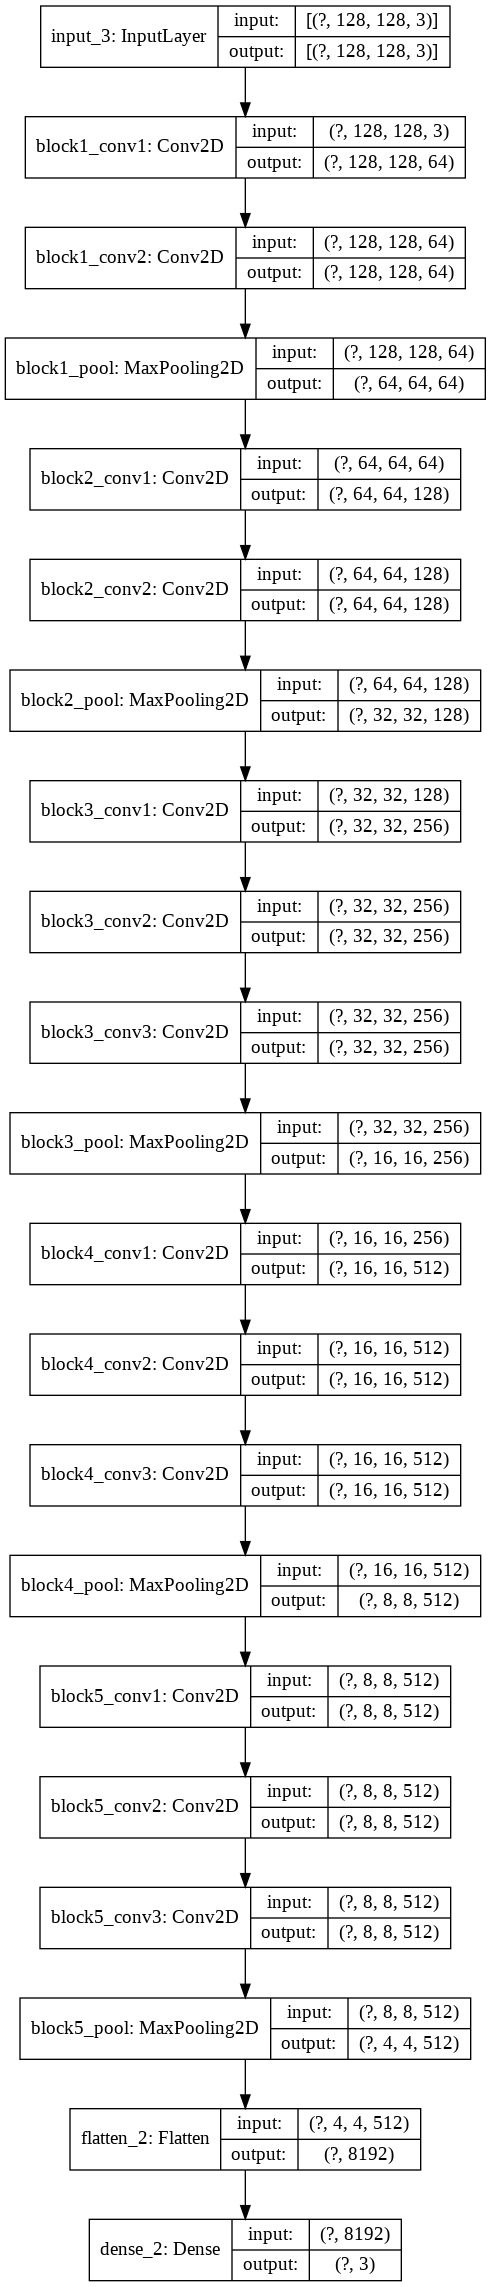

In [13]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model3 = Model(vgg.input, x)
model3.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model3, "third_model.png",show_shapes=True)

train model3

In [14]:
# needs steps per epoch since the generator is infinite
model3.fit_generator(natural_cat_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

Epoch 1/5
64/64 [==============================] - 9s 143ms/step - loss: 1.0073
Epoch 2/5
64/64 [==============================] - 9s 144ms/step - loss: 0.6343
Epoch 3/5
64/64 [==============================] - 9s 142ms/step - loss: 0.6233
Epoch 4/5
64/64 [==============================] - 9s 142ms/step - loss: 0.5803
Epoch 5/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5755


examine results

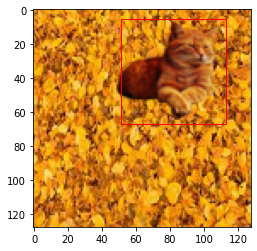

In [15]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(natural_cat_gen())
# predict
pred = model3.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)

# Fourth Step

**fourth step** - detect if there is a cat over a natural background

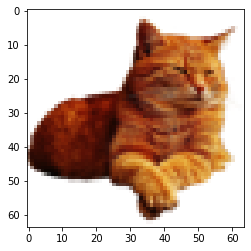

(64, 64, 4)

In [16]:
from PIL import Image

cat_pil = Image.open("cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)
plt.imshow(cat)
plt.show()

cat.shape

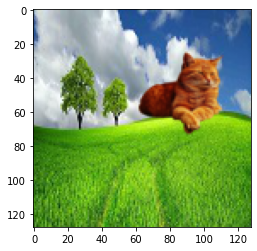

In [17]:
def natural_cat_gen2(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 4))
      # fill each image
      for i in range(batch_size):
        # resize the cat
        size = np.random.randint(32,64)
        temp_cat = cat_pil.resize((size,size))
        cat = np.asarray(temp_cat) / 255.
        cat_x, cat_y, _ = cat.shape
        # background image
        bg_name = f'bg{np.random.randint(1,4)}.jpg'
        bg = Image.open(bg_name)

        x1 = np.random.randint(1,128 - cat_x)
        y1 = np.random.randint(1,128 - cat_y)
        h = cat_x
        w = cat_y
        # draw the cat with probability 0.8
        cat_appear = 0.0
        if(np.random.uniform(low=0.0,high=1.0) < 0.8):
          cat_appear = 1.0
          bg.paste(temp_cat, (x1, y1),mask=temp_cat)
        cat = np.asarray(bg) / 255.
        X[i] = cat

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = cat_x / 128.
        Y[i,3] = cat_appear
      yield X, Y

# sanity check - plot the images
x,y = next(natural_cat_gen2())
plt.imshow(x[0])

We can still use crossentropy as a loss but we need to pay attention:
When there is no cat, a vanilla crossentropy will still take into account the predictions for the bounding box. To avoid this, we will create a custom loss:

In [18]:
def custom_loss(y_true, y_pred):
  # y_true shape is [BATCH, 4], 
  # y_true[:,:3] -> location
  # y_true[:,-1] -> is there a cat

  location_bce = tf.keras.losses.binary_crossentropy(y_true[:, :3], y_pred[:, :3])
  is_there_bce = tf.keras.losses.binary_crossentropy(y_true[:, -1], y_pred[:, -1])

  return (location_bce * y_true[:, -1]) + is_there_bce

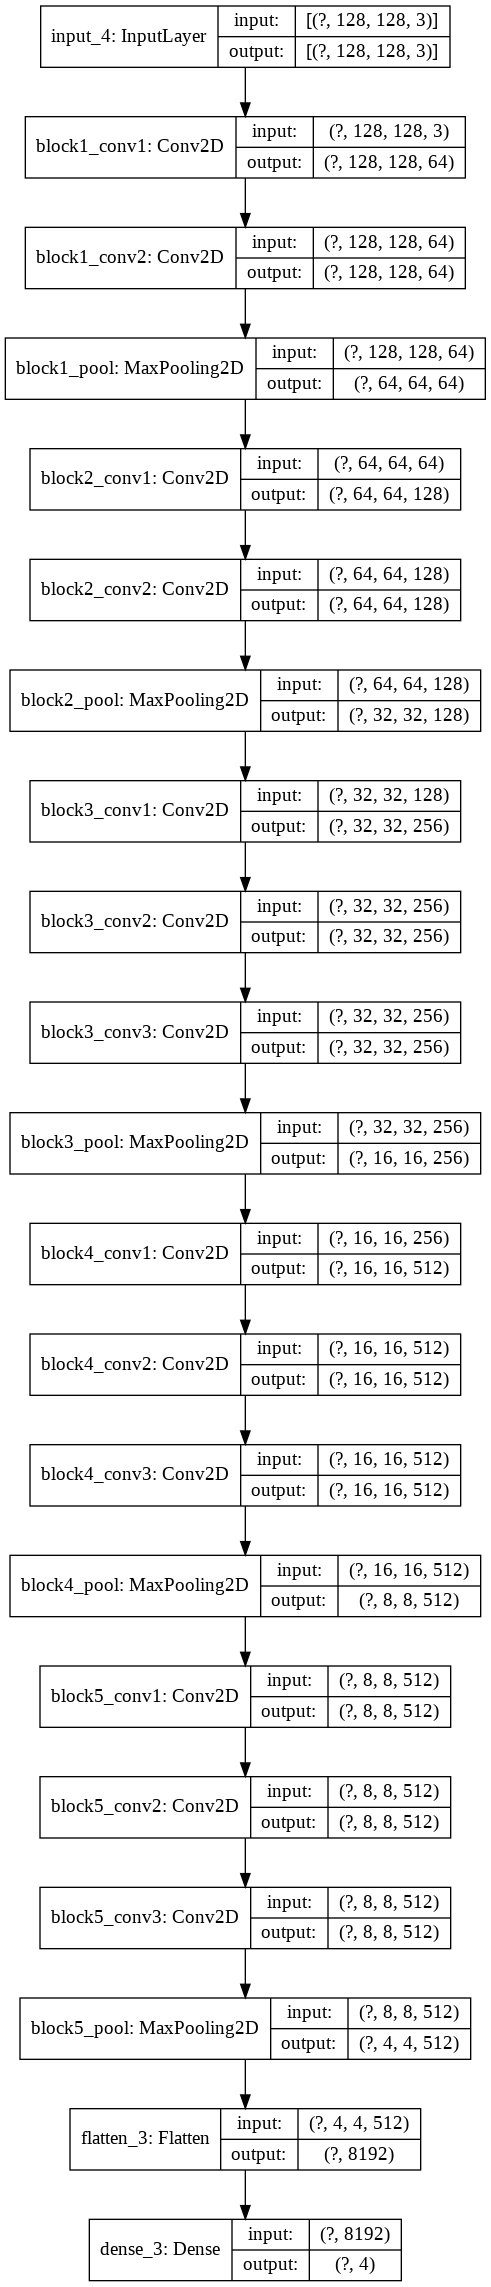

In [19]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model4 = Model(vgg.input, x)
model4.compile(loss=custom_loss, optimizer=Adam(lr=0.001))
# plot the model
plot_model(model4, "fourth_model.png",show_shapes=True)

In [20]:
# needs steps per epoch since the generator is infinite
model4.fit_generator(natural_cat_gen2(),steps_per_epoch=EPOCH_SIZE,epochs=5)

Epoch 1/5
64/64 [==============================] - 9s 143ms/step - loss: 1.2078
Epoch 2/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5632
Epoch 3/5
64/64 [==============================] - 9s 142ms/step - loss: 0.4518
Epoch 4/5
64/64 [==============================] - 9s 143ms/step - loss: 0.4522
Epoch 5/5
64/64 [==============================] - 9s 143ms/step - loss: 0.4621


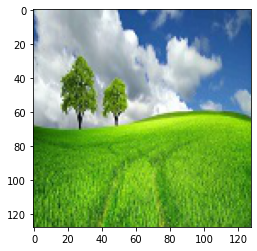

In [21]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  if(p[3]>0.5):
    rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(natural_cat_gen2())
# predict
pred = model4.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)

# Fifth Step

**Fifth Step** - detect objects from multiple classes

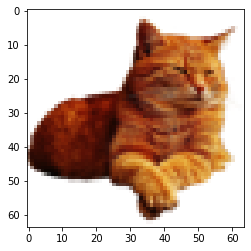

cat.shape = (64, 64, 4)


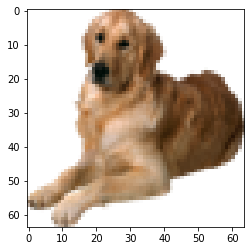

dog.shape = (64, 64, 4)


In [22]:
from PIL import Image

# load cat 
cat_pil = Image.open("cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)
plt.imshow(cat)
plt.show()

print(f'cat.shape = {cat.shape}')

# load dog
dog_pil = Image.open("dog.png")
dog_pil = dog_pil.resize((64,64))
dog = np.asarray(dog_pil)
plt.imshow(dog)
plt.show()

print(f'dog.shape = {dog.shape}')

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


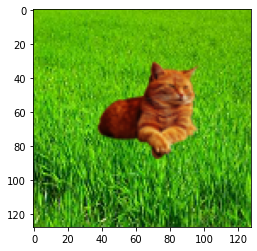

In [23]:
def flip_coin():
  if np.random.uniform()>0.5:
    return 'cat'
  return 'dog'

def natural_cat_dog_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 6))
      # fill each image
      for i in range(batch_size):
        size = np.random.randint(32,64)
        # choose cat or dog
        cat = 0.0
        dog = 0.0
        if(flip_coin() == 'cat'):
          # resize the cat
          temp_im = cat_pil.resize((size,size))
          temp_im_np = np.asarray(temp_im) / 255.
          animal_x, animal_y, _ = temp_im_np.shape
          cat = 1.0
        else:
          temp_im = dog_pil.resize((size,size))
          temp_im_np = np.asarray(temp_im) / 255.
          animal_x, animal_y, _ = temp_im_np.shape
          dog = 1.0

        # background image
        bg_name = f'bg{np.random.randint(1,4)}.jpg'
        bg = Image.open(bg_name)

        x1 = np.random.randint(1,128 - animal_x)
        y1 = np.random.randint(1,128 - animal_y)
        h = animal_x
        w = animal_y
        # draw the cat with probability 0.8
        animal_appear = 0.0
        if(np.random.uniform(low=0.0,high=1.0) < 0.8):
          animal_appear = 1.0
          bg.paste(temp_im, (x1, y1),mask=temp_im)
        pic = np.asarray(bg) / 255.
        X[i] = pic

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = animal_x / 128.
        Y[i,3] = animal_appear * cat // 1 # is_cat
        Y[i,4] = animal_appear * dog // 1 # is_dog
        Y[i,5] = (1. - animal_appear) // 1

      yield X, Y

# sanity check - plot the images
x,y = next(natural_cat_dog_gen())
plt.imshow(x[0])

print(y[:, 3:])

In [24]:
def custom_loss2(y_true, y_pred):
  # y_true shape is [BATCH, 6], 
  # y_true[:,:3] -> location
  # y_true[:,3] -> is there a cat
  # y_true[:,4] -> is there a dog
  # y_true[:,5] -> is there a void

  location_bce = tf.keras.losses.binary_crossentropy(y_true[:, :3], y_pred[:, :3])
  cls_cce = tf.keras.losses.categorical_crossentropy(y_true[:, 3:], y_pred[:, 3:])

  is_animal = 1 - (y_true[:, -1])

  return (location_bce * is_animal) + 5 * cls_cce

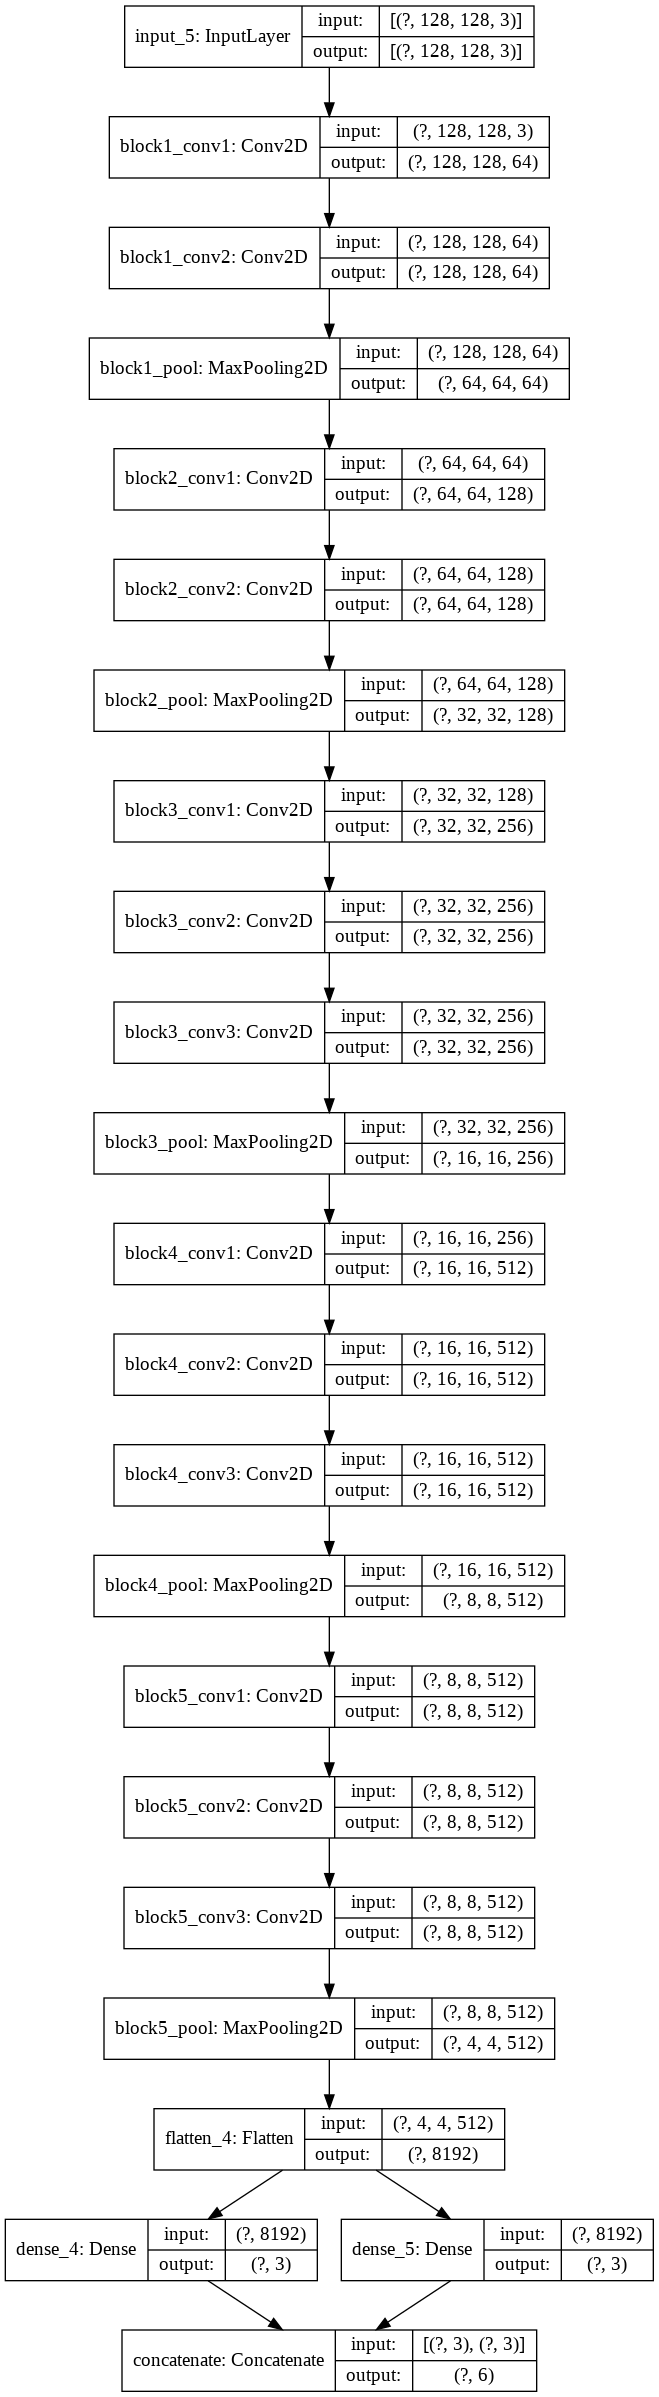

In [25]:
from tensorflow.keras.layers import Concatenate

# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x1 = Dense(3, activation='sigmoid')(x)
x2 = Dense(3, activation='softmax')(x)
out = Concatenate()([x1, x2])
model5 = Model(vgg.input, out)
model5.compile(loss=custom_loss2, optimizer=Adam(lr=0.001))
# plot the model
plot_model(model5, "fifth.png",show_shapes=True)

In [26]:
# needs steps per epoch since the generator is infinite
model5.fit_generator(natural_cat_dog_gen(),steps_per_epoch=10*EPOCH_SIZE,epochs=5)

Epoch 1/5
640/640 [==============================] - 93s 145ms/step - loss: 2.6518
Epoch 2/5
640/640 [==============================] - 93s 145ms/step - loss: 0.4627
Epoch 3/5
640/640 [==============================] - 93s 145ms/step - loss: 0.4590
Epoch 4/5
640/640 [==============================] - 93s 145ms/step - loss: 0.4570
Epoch 5/5
640/640 [==============================] - 93s 145ms/step - loss: 0.4593


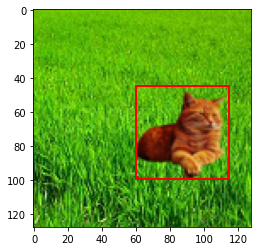

In [27]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  if(np.argmax(p[3:])==0): # cat
    rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  elif(np.argmax(p[3:])==1): # dog
    rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=2,edgecolor='y',facecolor='none')
    ax.add_patch(rect)
  plt.show()


# generate new image
x, y = next(natural_cat_dog_gen())
# predict
pred = model5.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)